In [1]:
!pip install xgboost 

In [2]:
import numpy as np 
import pandas as pd 
import xgboost as xg 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 

In [3]:
!pip install openpyxl

# Getting dataset and clean sample with NaN in Grain.As

```dataset``` for full dataset : 692 sample

```cleaned_dataset``` for cleaned dataset (removed samples with null Asen values) : 669 samples

In [4]:
# Load the dataset
dataset = pd.read_excel(r'D:\project\Asen_Accumulation\data\16-Aviric.xlsx')

# Drop rows where 'Grain_As' column has missing values
cleaned_dataset = dataset.dropna(subset=['Grain.As'])

In [5]:
# Check the cleaned dataset
print(f"Original dataset shape: {dataset.shape}")
print(f"Cleaned dataset shape: {cleaned_dataset.shape}")
print(cleaned_dataset.head())

Original dataset shape: (693, 29)
Cleaned dataset shape: (669, 29)
  Sample.code  Lattitude    Longitude        Season.planted  Grain.As  \
0   23Vin1_#1   10.105651  105.894707  Winter-Spring season  0.523334   
1   23Vin2_#1   10.071678  105.927982  Winter-Spring season  0.312485   
2   23Vin3_#1   10.073358  105.992213  Winter-Spring season  0.058160   
3   23Vin4_#1   10.142449  106.021702  Winter-Spring season  0.037008   
4   23Vin5_#1   10.075267  106.170488  Winter-Spring season  0.170522   

       Grain.P      Grain.S   Grain.Mn   Grain.Fe  Grain.Cu  ...   Soil.S  \
0  2984.341641  1092.869532  22.782137  28.896448  2.074383  ...  1161.03   
1  3127.027761  1131.268467  19.842637   1.784861  2.024729  ...  1664.97   
2  3195.274467   991.132283  17.984741  41.951877  1.626614  ...   803.94   
3  2682.304757   855.024208  16.678840   1.100623  1.760309  ...  2331.02   
4  2963.072168   810.699618  15.986882   3.180604  0.975245  ...   458.27   

   Soil.Mn   Soil.Fe  Soil.pH  

# Clear outliers in data


- Using histplot and boxplot to see values distribution 
- Using IQR to remove outliers (big Grain Asen outliers)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


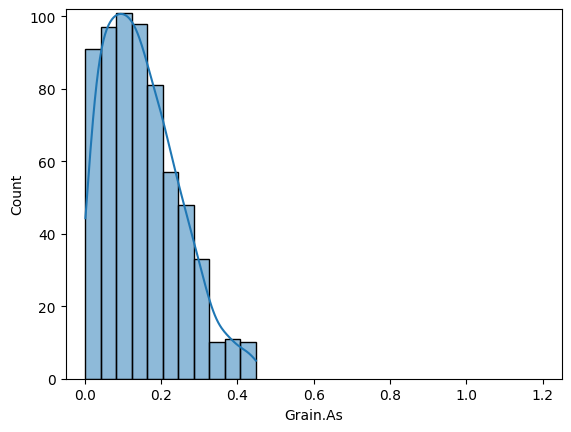

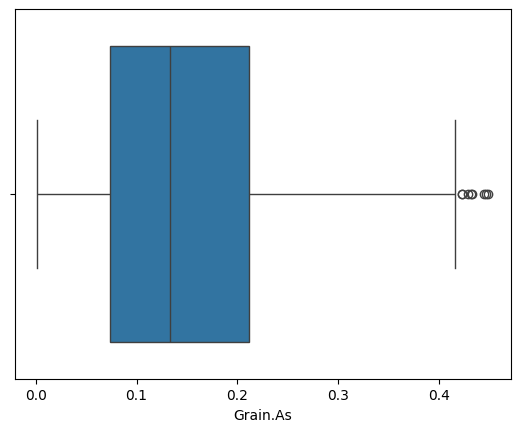

In [42]:
raw_data = cleaned_dataset

sns.histplot(raw_data['Grain.As'] , bins = 11 , kde = True)
plt.xlim(-0.05 , 1.25)
plt.ylim(0 , 102)
plt.show()

sns.boxplot(x = raw_data['Grain.As'])
plt.show()

In [8]:
# raw_data = cleaned_dataset

Q1 = raw_data['Grain.As'].quantile(0.25)
Q3 = raw_data['Grain.As'].quantile(0.75)
IQR = Q3-Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3 + 1.5*IQR



# I tended to remove outliers but to compare to other algorithm (XGBoost) I have to use the whole dataset without removing outliers 
cleaned_dataset = cleaned_dataset[(cleaned_dataset['Grain.As'] >= lower_bound) & (cleaned_dataset['Grain.As'] <= upper_bound)]

In [40]:
import os

In [41]:
df = cleaned_dataset

# Define folder and file path
folder_path = r"D:\project\Asen_Accumulation\data"
file_path = os.path.join(folder_path, "dataset.csv")

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Save DataFrame to CSV
df.to_csv(file_path, index=False)

print(f"Dataset saved to {file_path}")



Dataset saved to D:\project\Asen_Accumulation\data\dataset.csv


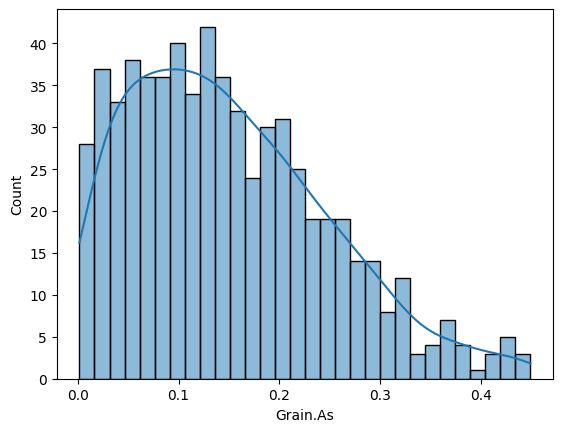

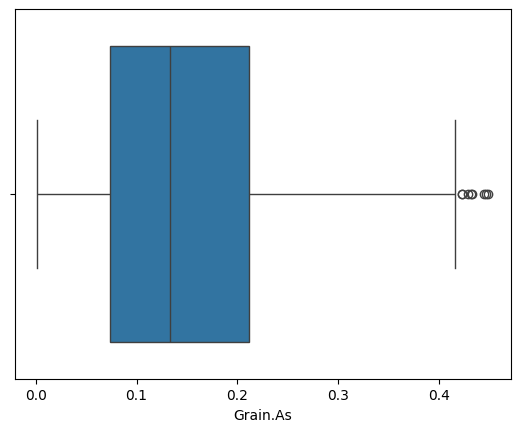

In [10]:

sns.histplot(cleaned_dataset['Grain.As'] , bins = 30 , kde = True)
plt.show()

sns.boxplot(x = cleaned_dataset['Grain.As'])
plt.show()

# Writing functions to make experiments 

```training``` : for training

- geting parameter ```dataset``` , ```params``` for XGboost , ```num_boost_round``` , ```seed``` 
 
- ```training``` return: ```model``` after trained ,  training result ```evals_result``` , ```test_X```, ```test_y``` for plotting a visual plot of prediction 

- If KFold is neccessary , change this function

```plot_training_curve```: exactly like what it is called 

- Input: ```evals_results``` got from training process 


```plot_prediction```: use model to prediction and plot how closed prediction to label 



In [11]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold

In [12]:
# Parameters for XGboost algorigthm 


params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 4,
    'eta': 0.1,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'seed': 42
}


seed = 123
num_boost_round = 300



In [13]:
def training(dataset, params, num_boost_round, seed = seed):
    X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
    train_X , test_X , train_y ,  test_y = train_test_split(X , y , test_size = 0.3 , random_state= seed)
    train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
    test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)

    evals_result = {}


    model = xg.train(params , train_dmatrix, 
        num_boost_round=num_boost_round, 
        evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
        evals_result=evals_result,  
        verbose_eval=False)
    
    return model , evals_result , test_X ,  test_y


In [14]:
def plot_training_curve(evals_result, data_name):
        
    # Extract RMSE values
    train_rmse = evals_result['train']['rmse']
    test_rmse = evals_result['test']['rmse']

    print(f"RMSE {min(test_rmse )}") 

    # Plot both Training and Test RMSE
    plt.plot(range(1, len(train_rmse) + 1), train_rmse, label="Train RMSE", linestyle="--")
    plt.plot(range(1, len(test_rmse) + 1), test_rmse, label="Test RMSE")
    plt.xlabel("Boosting Round")
    plt.ylabel("RMSE")
    plt.ylim(0, 0.12)
    plt.grid(True)
    plt.title(f"XGBoost Training & Test RMSE Over Boosting Rounds {data_name}")
    plt.legend()
    plt.show()






In [15]:
def plot_prediction(model , test_X , test_y , dataname):
   
    test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)

        
    # xgb_r = xg.train(params = params, dtrain = train_dmatrix, num_boost_round = 10) 
    pred = model.predict(test_dmatrix) 
    
    # RMSE Computation 
    # rmse = np.sqrt(MSE(test_y, pred)) 
    


    # type(test_y)
    result = pd.DataFrame(test_y)
    result['predict'] = pred

    result['difference_percent'] = abs(result['Grain.As'] - result['predict'])/result['Grain.As']*100

    y_true = result['Grain.As']

    r2 = r2_score(y_true , pred)
    print(f"R2 score : {r2}")


    plt.scatter(result['Grain.As'], result['predict'], alpha=0.5)
    plt.plot([-0.05, 0.5], [-0.05, 0.5], color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylim(-0.05, 0.5)
    plt.xlim(-0.05, 0.5)
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted in {dataname}")
    plt.show()


    
        


In [16]:
def run_kfold(params , dataset, dataname,  location = True , cv = 5 , plot_result = False , seed = seed ):
    kfold = KFold(cv , shuffle = True , random_state=seed)

    if location:
        X , y = dataset.iloc[: , [1, 2] + list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]
    else:
        X , y = dataset.iloc[: ,list(range(5, dataset.shape[1]))] , dataset.iloc[: , 4]


    test_rmse = []
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        evals_result = {}
        print(f"Training fold {fold+1}/{cv}")

        train_X, test_X = X.iloc[train_idx] , X.iloc[test_idx]
        train_y  , test_y = y.iloc[train_idx] , y.iloc[test_idx]

        train_dmatrix = xg.DMatrix(data = train_X , label = train_y , missing = np.nan)
        test_dmatrix = xg.DMatrix(data = test_X , label = test_y, missing = np.nan)
        model = xg.train(params , train_dmatrix, 
            num_boost_round=num_boost_round, 
            evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],  # Log training and test RMSE
            evals_result=evals_result,  
            verbose_eval=False )
        
        min_test_rmse = min(evals_result['test']['rmse'])
        test_rmse.append(min_test_rmse)


        # pred = model.predict(test_dmatrix)
        # r2 = r2_score(pred , test_y)
        

        print(f"Fold {fold + 1} RMSE: {min_test_rmse:.4f}\n")

        
        if plot_result == True and fold == cv-1:
            plot_training_curve(evals_result , dataname)
            plot_prediction(model , test_X , test_y , dataname)

        
    return test_rmse



        




        



    

Training fold 1/5
Fold 1 RMSE: 0.0722

Training fold 2/5
Fold 2 RMSE: 0.0701

Training fold 3/5
Fold 3 RMSE: 0.0721

Training fold 4/5
Fold 4 RMSE: 0.0606

Training fold 5/5
Fold 5 RMSE: 0.0635

RMSE 0.06350037858263549


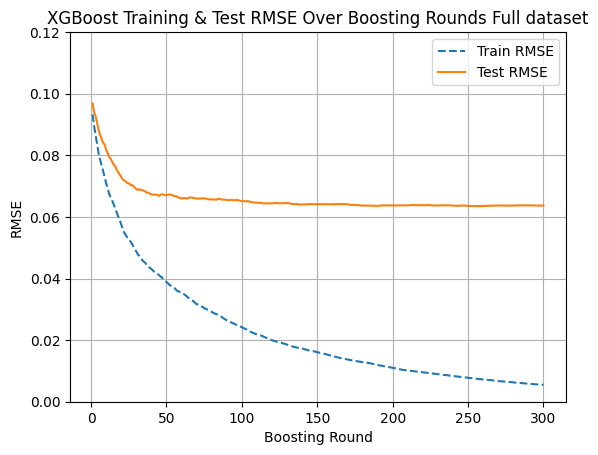

R2 score : 0.5953613433570963


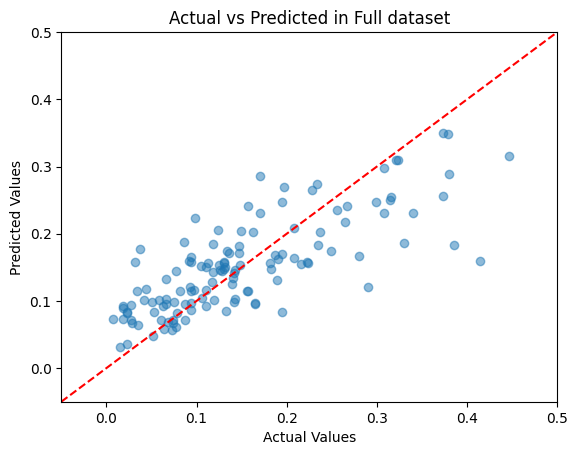

RMSE for full dataset with location : 0.06769323365382496


In [17]:
# #predict for the whole dataset (without rows having missing values on Grain.As)

dataname = "Full dataset"

# model1 , evals_result , test_X , test_y = training(cleaned_dataset , params , num_boost_round )

# plot_training_curve(evals_result , dataname)

# plot_prediction(model1 , test_X , test_y , dataname)


full_data_rmse = run_kfold(params , dataset = cleaned_dataset, dataname= dataname, location=True , plot_result= True)
print(f"RMSE for full dataset with location : {np.mean(full_data_rmse)}")

# Split the whole data set into different datasets for different crops

I suspect that the techniques to grow fields is different between crops, which can affects on the quality and chemical accumulation in grain/straw/soil. 
So I split dataset into: Winter-Spring season and Summer-Autumn season. This technique will further decrease RMSE on Asen cummulation prediction.

In [18]:
print(cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']['Grain.As'].mean() , cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']['Grain.As'].var() )
print(cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']['Grain.As'].mean() , cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']['Grain.As'].var())
WS_data = cleaned_dataset[cleaned_dataset['Season.planted'] == 'Winter-Spring season']

SA_data = cleaned_dataset[cleaned_dataset['Season.planted'] == 'Summer-Autumn season']

print(len(WS_data) , len(SA_data))

0.14854501699564446 0.008370063026122346
0.1510027152334953 0.012802412757765854
462 175


# Predict with Winter spring crops 

Training fold 1/5
Fold 1 RMSE: 0.0787

Training fold 2/5
Fold 2 RMSE: 0.0627

Training fold 3/5
Fold 3 RMSE: 0.0671

Training fold 4/5
Fold 4 RMSE: 0.0649

Training fold 5/5
Fold 5 RMSE: 0.0681

RMSE 0.06809991071423886


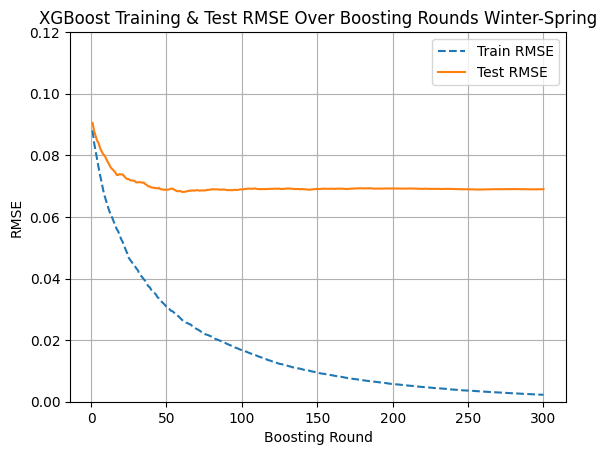

R2 score : 0.4318061003306055


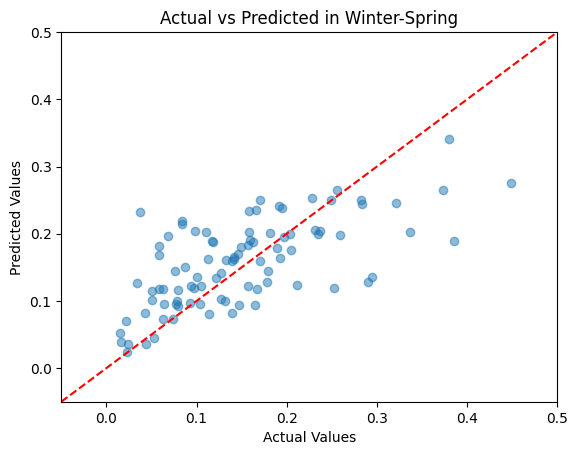

RMSE for Winter-spring dataset with location : 0.06830415407365867


In [19]:
# #predicting for winter spring crops

dataname = "Winter-Spring"

# model1 , evals_result , test_X , test_y = training(WS_data , params , num_boost_round )

# plot_training_curve(evals_result , dataname)

# plot_prediction(model1 , test_X , test_y ,  dataname)

WS_rmse = run_kfold(params , WS_data , dataname , location=True , plot_result= True)
print(f"RMSE for Winter-spring dataset with location : {np.mean(WS_rmse)}")


# Predict for summer-autumn crops

Training fold 1/5
Fold 1 RMSE: 0.0661

Training fold 2/5
Fold 2 RMSE: 0.0524

Training fold 3/5
Fold 3 RMSE: 0.0621

Training fold 4/5
Fold 4 RMSE: 0.0579

Training fold 5/5
Fold 5 RMSE: 0.0639

RMSE 0.06389425835599512


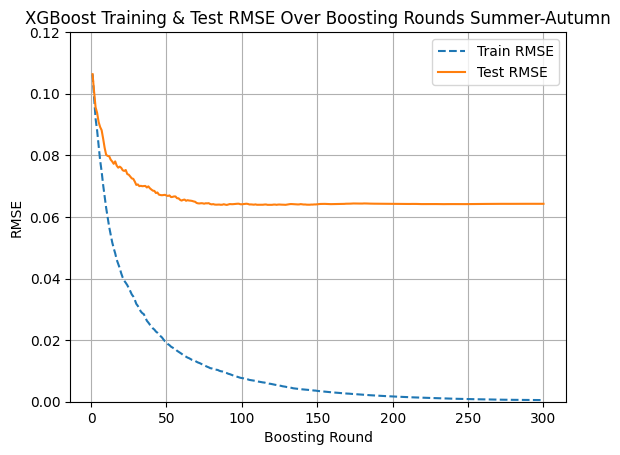

R2 score : 0.6471434997248766


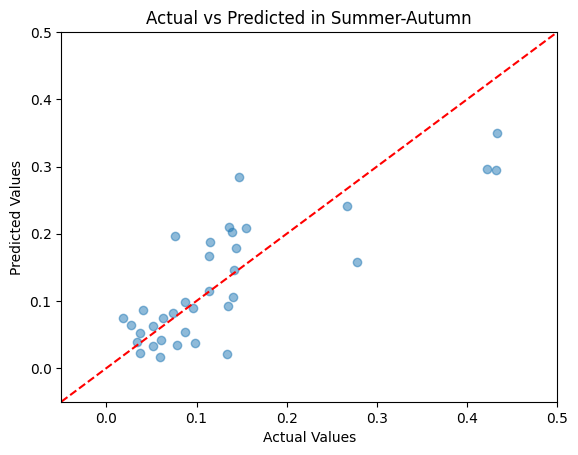

RMSE for Winter-spring dataset with location : 0.06047843921660183


In [20]:
# #predicting for summer_autumn crops

dataname = "Summer-Autumn"

# model1 , evals_result , test_X , test_y = training(SA_data , params , num_boost_round )

# plot_training_curve(evals_result , dataname)

# plot_prediction(model1 , test_X , test_y , dataname)

SA_rmse = run_kfold(params , SA_data , dataname , location=True , plot_result= True)
print(f"RMSE for Winter-spring dataset with location : {np.mean(SA_rmse)}")




In [21]:
cleaned_dataset.iloc[:5 , :16]

,Sample.code,Lattitude,Longitude,Season.planted,Grain.As,Grain.P,Grain.S,Grain.Mn,Grain.Fe,Grain.Cu,Straw.As,Straw.Al,Straw.P,Straw.S,Straw.Mn,Straw.Fe
1,23Vin2_#1,10.071678,105.927982,Winter-Spring season,0.312485,3127.027761,1131.268467,19.842637,1.784861,2.024729,0.707296,249.273175,1136.949392,1376.276784,797.197832,217.919123
2,23Vin3_#1,10.073358,105.992213,Winter-Spring season,0.058160,3195.274467,991.132283,17.984741,41.951877,1.626614,0.526424,203.703811,1256.785962,1162.890087,263.397595,271.415308
3,23Vin4_#1,10.142449,106.021702,Winter-Spring season,0.037008,2682.304757,855.024208,16.678840,1.100623,1.760309,0.489382,382.900847,2626.530750,2375.451115,864.473531,356.117865
4,23Vin5_#1,10.075267,106.170488,Winter-Spring season,0.170522,2963.072168,810.699618,15.986882,3.180604,0.975245,4.031916,533.999448,1954.781134,738.888980,636.466670,493.523147
5,23Vin6_#1,10.124319,106.564796,Winter-Spring season,0.196503,2588.389913,632.192396,8.606428,17.835252,0.303528,1.786458,465.812192,1444.755938,1330.030520,269.060354,1066.511115


# Using location (lattitude and longtitude) for predicting Arsenic accumulation 

Because different areas have different climates, so farmer have to choose types of tree to grow. Different types of tree have different abilities of chemical accumulation 

### below experiment is taken earlier  


In [22]:
# #predict for the whole dataset (without rows having missing values on Grain.As)



In [23]:
# #predict for the whole dataset (without rows having missing values on Grain.As)


In [24]:
for i in range(len(cleaned_dataset.columns)):
    print(i , cleaned_dataset.columns[i])

0 Sample.code
1 Lattitude 
2 Longitude
3 Season.planted
4 Grain.As
5 Grain.P
6 Grain.S
7 Grain.Mn
8 Grain.Fe
9 Grain.Cu
10 Straw.As
11 Straw.Al
12 Straw.P
13 Straw.S
14 Straw.Mn
15 Straw.Fe
16 Soil.As
17 Soil.Al
18 Soil.P
19 Soil.S
20 Soil.Mn
21 Soil.Fe
22 Soil.pH
23 Soil.Clay
24 Soil.SOM
25 Temperature
26 Rainfall
27 Humidity
28 Potential.Evaporation


### below is experiment not using location

In [25]:
# #predict for the whole dataset (without rows having missing values on Grain.As)






In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

### below are encoding Season to a feature and then use it for XGboost in full dataset

### below are experiment only using high correlated values with Grain Asen

In [27]:
# #predict for the whole dataset (without rows having missing values on Grain.As)


# Using KFold to evaluate as if location is truely neccessary 

Training fold 1/6
Fold 1 RMSE: 0.0738

Training fold 2/6
Fold 2 RMSE: 0.0653

Training fold 3/6
Fold 3 RMSE: 0.0737

Training fold 4/6
Fold 4 RMSE: 0.0706

Training fold 5/6
Fold 5 RMSE: 0.0548

Training fold 6/6
Fold 6 RMSE: 0.0638

RMSE 0.0638462325577686


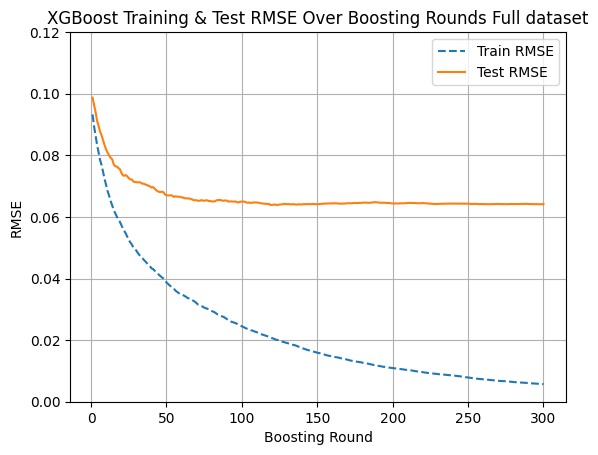

R2 score : 0.6014547497519767


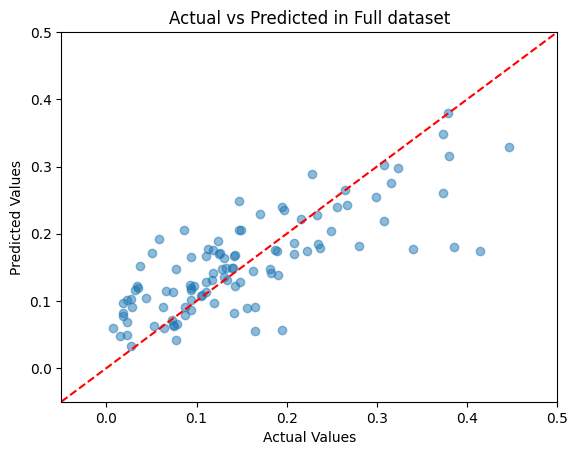

Training fold 1/6
Fold 1 RMSE: 0.0750

Training fold 2/6
Fold 2 RMSE: 0.0666

Training fold 3/6
Fold 3 RMSE: 0.0778

Training fold 4/6
Fold 4 RMSE: 0.0733

Training fold 5/6
Fold 5 RMSE: 0.0602

Training fold 6/6
Fold 6 RMSE: 0.0664

RMSE 0.06644746863618428


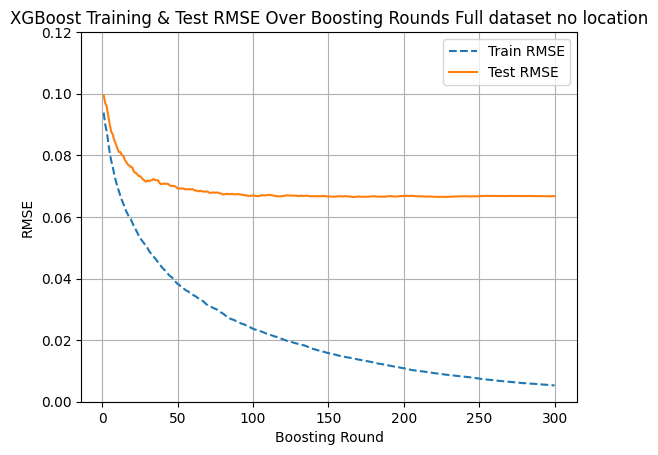

R2 score : 0.5684361835304019


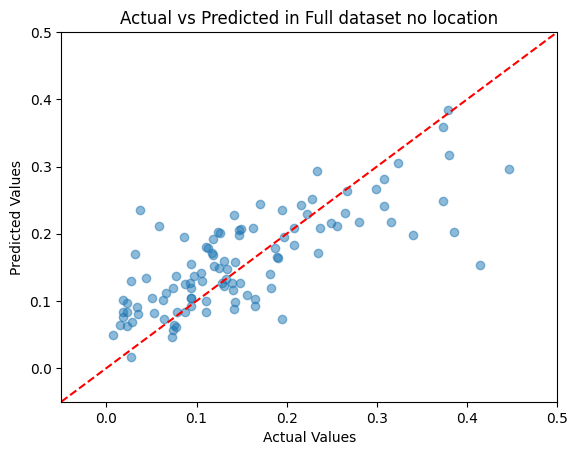

In [28]:
# For full dataset 

test_rmse_with_location = run_kfold(params , cleaned_dataset , "Full dataset" , location=True , cv=6, plot_result= True)

test_rmse_without_location = run_kfold(params , cleaned_dataset , "Full dataset no location" , location=False , cv = 6, plot_result= True)





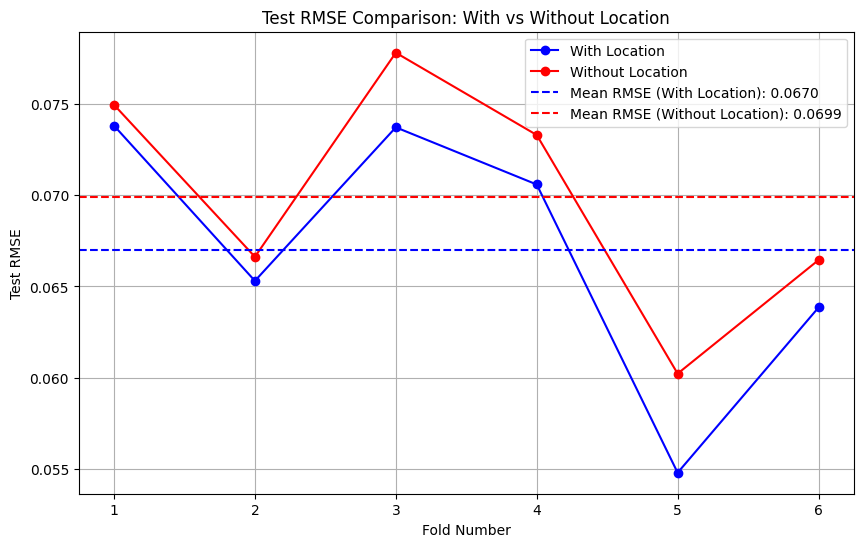

In [29]:




# Number of folds
num_folds = len(test_rmse_with_location)

# Create x-axis values (fold numbers)
folds = np.arange(1, num_folds + 1)

# Calculate mean RMSE for both scenarios
mean_rmse_with_location = np.mean(test_rmse_with_location)
mean_rmse_without_location = np.mean(test_rmse_without_location)

# Plotting
plt.figure(figsize=(10, 6))

# Plot RMSE for each fold
plt.plot(folds, test_rmse_with_location, marker='o', label='With Location', color='blue')
plt.plot(folds, test_rmse_without_location, marker='o', label='Without Location', color='red')

# Plot mean RMSE lines
plt.axhline(mean_rmse_with_location, color='blue', linestyle='--', label=f'Mean RMSE (With Location): {mean_rmse_with_location:.4f}')
plt.axhline(mean_rmse_without_location, color='red', linestyle='--', label=f'Mean RMSE (Without Location): {mean_rmse_without_location:.4f}')

# Add labels and title
plt.xlabel('Fold Number')
plt.ylabel('Test RMSE')
plt.title('Test RMSE Comparison: With vs Without Location')
plt.xticks(folds)  # Ensure x-axis shows fold numbers
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Finetune XGBoost Parameters 

In [30]:
def run_multiple_kfold(params , max_depth =False , eta = False , Subsample = False , Colsample = False):
    tmp_params = params
    result = pd.DataFrame()
    if max_depth:
        for i in range(3,10):
            tmp_params['max_depth'] = i
            test_rmse = run_kfold(tmp_params , cleaned_dataset, dataname="Full data" , location = True , plot_result= True)
            result[f'depth_{i}'] = test_rmse

    # if eta:
        # for i in range(5, 10):
        #     tmp_params['subsample']

    if Subsample:
        for i in range(5, 10):
            tmp_params['subsample'] = i/10
            test_rmse = run_kfold(tmp_params , cleaned_dataset , dataname= "Full data" , location= True , plot_result= True)
            result[f'subsample_{i/10:.1f}'] = test_rmse
    if Colsample:
        for i in range(5, 11):
            tmp_params['colsample_bytree'] = i/10
            test_rmse = run_kfold(tmp_params , cleaned_dataset , dataname= "Full data" , location= True , plot_result= True)
            result[f'cosample_{i/10:.1f}'] = test_rmse
        

    return result 

1. Finetune tree depth 

In [31]:

# result_finetune = run_multiple_kfold(params, max_depth=True )

In [32]:
# result_finetune

# for column in result_finetune.columns:
#     result_finetune.loc[5, column] = np.mean(result_finetune[column])

# result_finetune

We can conclude that Xgboost with trees having depth = 4 get the highest performance 

In [33]:
params['max_depth'] = 4 

2. Fine tune subsample 

In [34]:
# result_finetune = run_multiple_kfold(params , Subsample=True)


In [35]:
# # result_finetune = run_multiple_kfold(params , Subsample=True)

# for column in result_finetune.columns:
#     result_finetune.loc[5, column] = np.mean(result_finetune[column])

# result_finetune

We can conclude that subsample 0.6 would give the best performance

In [36]:
params['subsample'] = 0.6

3. Finetune cosample by tree

In [37]:
# result_finetune = run_multiple_kfold(params , Colsample= True)


In [38]:
# for column in result_finetune.columns:
#     result_finetune.loc[5, column] = np.mean(result_finetune[column])

# result_finetune

We can conclude that 0.8 for cosample by tree give the highest performance 

In [39]:
params['colsample_bytree'] = 0.8